# MODELS

## ARIMA

Auto Regressive Integrated Moving Average

In [1]:
!pip install pmdarima 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 34.0 MB/s eta 0:00:0000:01


In [2]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.pylab import rcParams
from pmdarima.arima import auto_arima
rcParams['figure.figsize'] = 10, 6

In [3]:
df = pd.read_csv('/kaggle/input/time-series-datasets/Electric_Production.csv')
df['DATE'] = pd.to_datetime(df['DATE'],infer_datetime_format=True)
df = df.set_index(['DATE'])
df.head(5)

,IPG2211A2N
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


### FUNCTIONALITIES TO ADD TO CLASS
        1. Train model/parameter tuning
        2. Forecasting
        3. Visualizations: Autocorrelation, Partial Autocorrelation, ETS Decomp


### Visualizations

In [4]:
df.index.name

'DATE'

In [5]:
def plot_series(df: pd.DataFrame):
    plt.xlabel(df.index.name)
    plt.ylabel(df.columns[0])
    plt.plot(df)
    plt.title('Series plot')

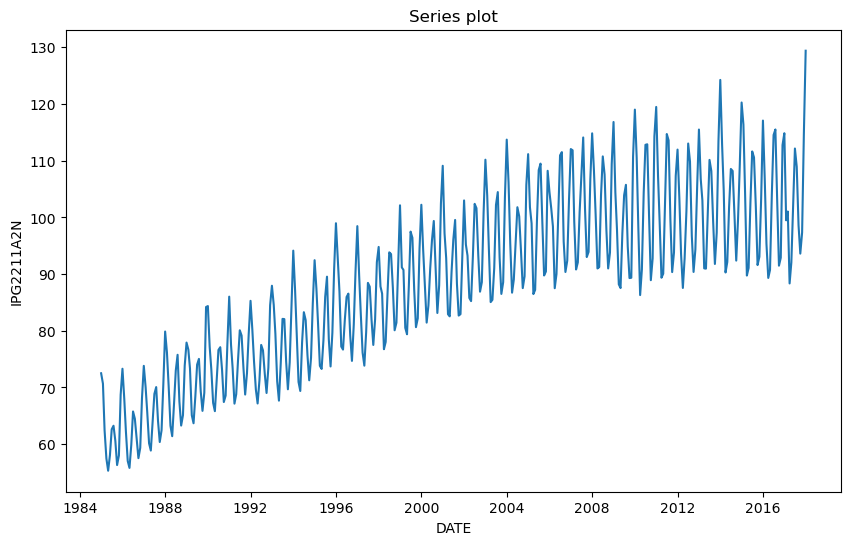

In [6]:
plot_series(df)

In [7]:
def plot_rolling_stats(df: pd.DataFrame, window: int):
    rolmean = df.rolling(window=12).mean()
    rolstd = df.rolling(window=12).std()
    orig = plt.plot(df, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

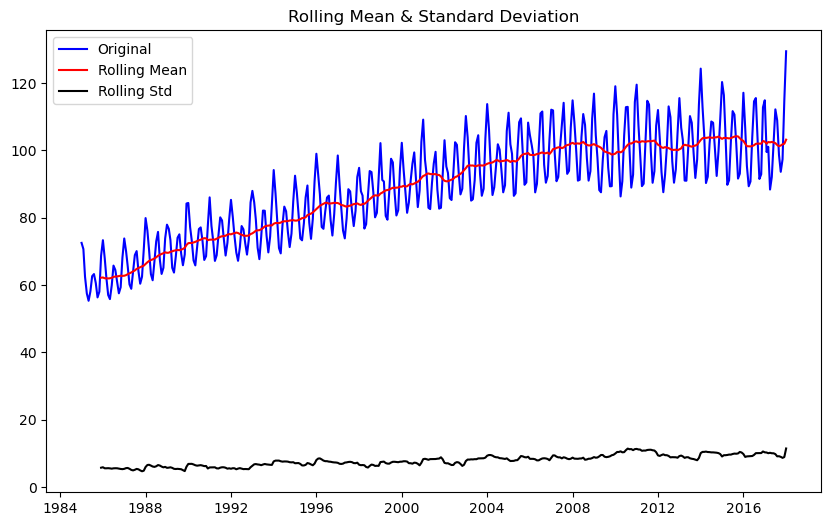

In [8]:
plot_rolling_stats(df, 12)

In [9]:
def test_stationarity(df: pd.DataFrame, col: str):
    # Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(df[col], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [10]:
test_stationarity(df, 'IPG2211A2N')

Results of Dickey Fuller Test:
Test Statistic                  -2.256990
p-value                          0.186215
#Lags Used                      15.000000
Number of Observations Used    381.000000
Critical Value (1%)             -3.447631
Critical Value (5%)             -2.869156
Critical Value (10%)            -2.570827
dtype: float64


In [11]:
def acf_differencing_plots(df, max_order):
    fig, axes = plt.subplots(max_order+1, 3)
    axes[0, 0].plot(df); axes[0, 0].set_title('Original Series')
    plot_acf(df, ax=axes[0, 1])
    plot_pacf(df, ax=axes[0, 2])
    
    
    for order in range(1, max_order+1):
        axes[order, 0].plot(df.diff(order)); axes[order, 0].set_title(str(order)+' Order Differencing')
        plot_acf(df.diff(order).dropna(), ax=axes[order, 1])
        plot_pacf(df.diff(order).dropna(), ax=axes[order, 2])
        
    plt.tight_layout()
        

/opt/conda/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/statsmodels/graphics/

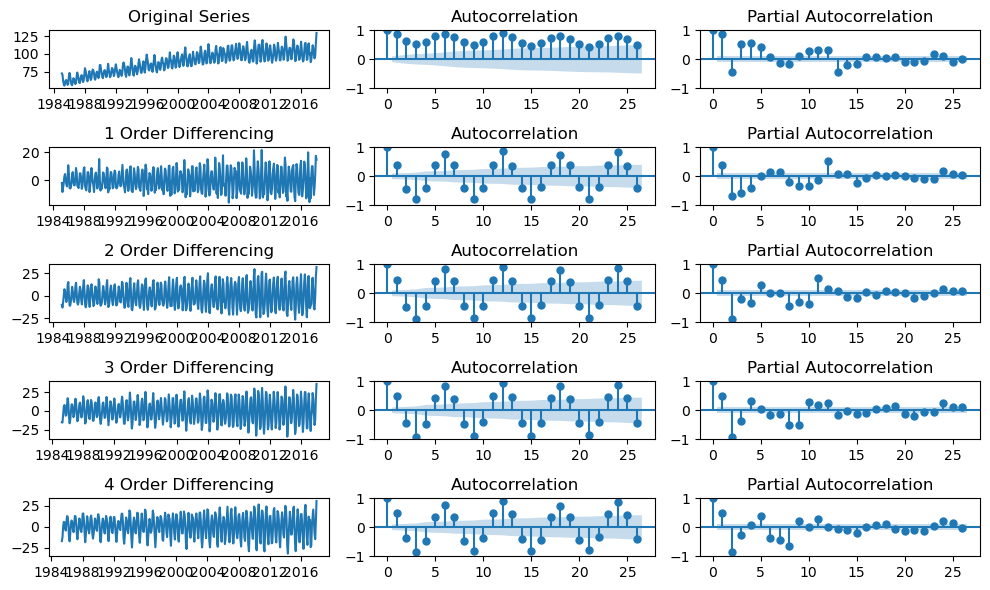

In [12]:
acf_differencing_plots(df, 4)

In [13]:
def ets_decomposition_plot(timeseries: pd.Series, plot = 'all'):
    if plot == 'all':
        seasonal_decompose(timeseries, model = 'multiplicative').plot()
    elif plot == 'seasonal':
        seasonal_decompose(timeseries, model = 'multiplicative').seasonal.plot()
    elif plot == 'error':
        seasonal_decompose(timeseries, model = 'multiplicative').resid.plot()
    elif plot == 'trend':
        seasonal_decompose(timeseries, model = 'multiplicative').trend.plot()
    else:
        print('Incorrect value \''+ plot + '\' for \'plot\'')
        
    

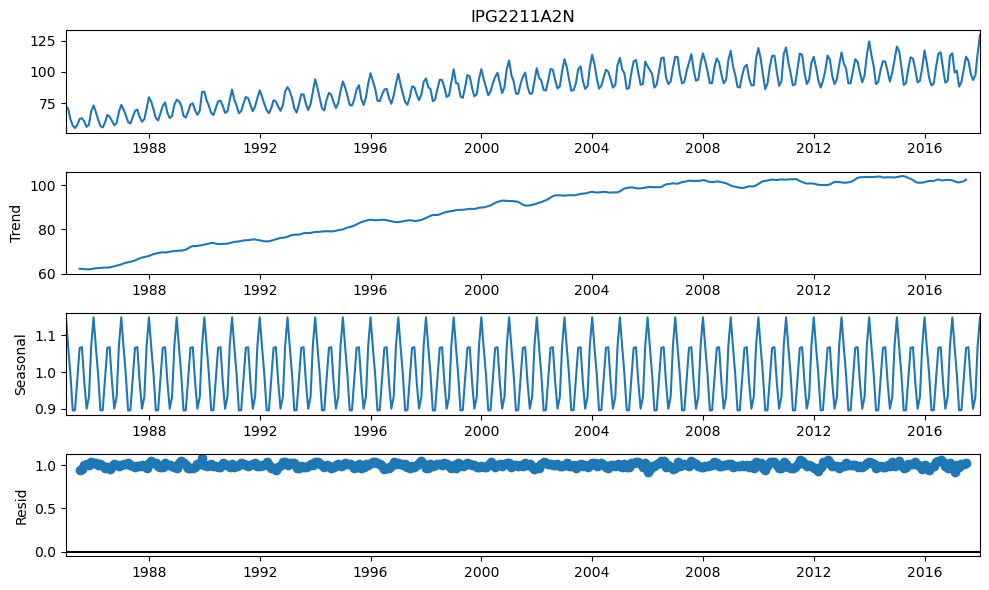

In [14]:
ets_decomposition_plot(df['IPG2211A2N'])

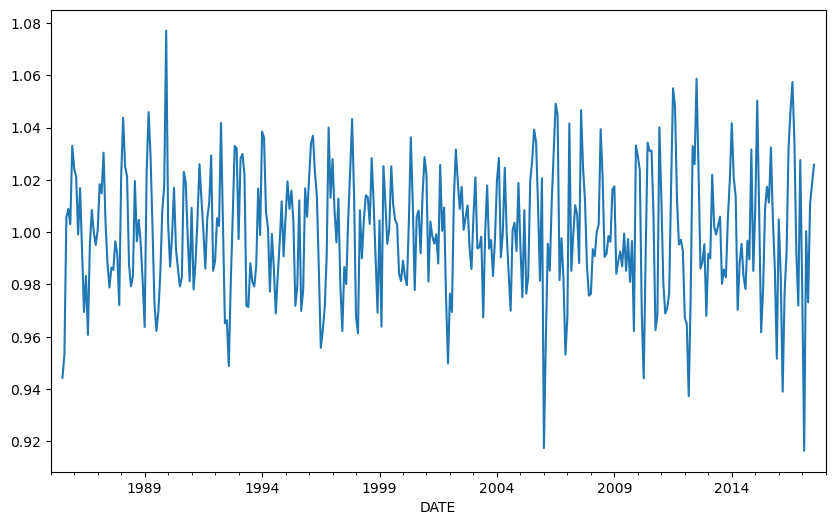

In [15]:
ets_decomposition_plot(df['IPG2211A2N'],'error')

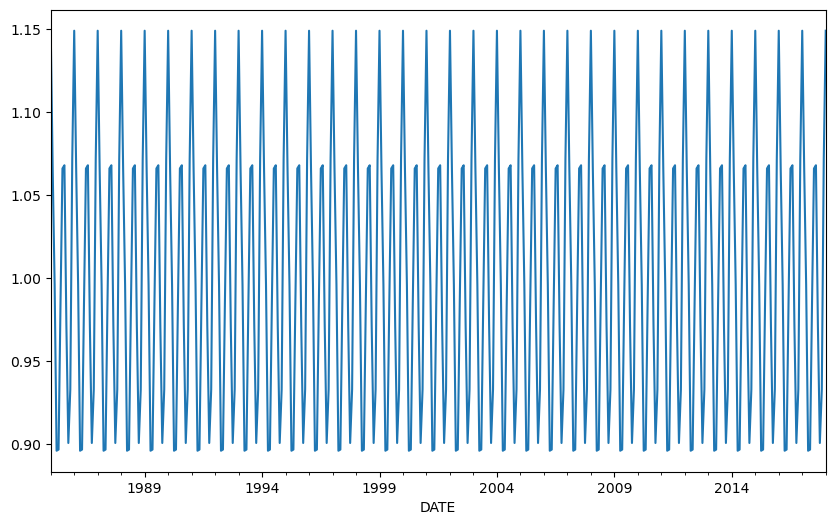

In [16]:
ets_decomposition_plot(df['IPG2211A2N'],'seasonal')

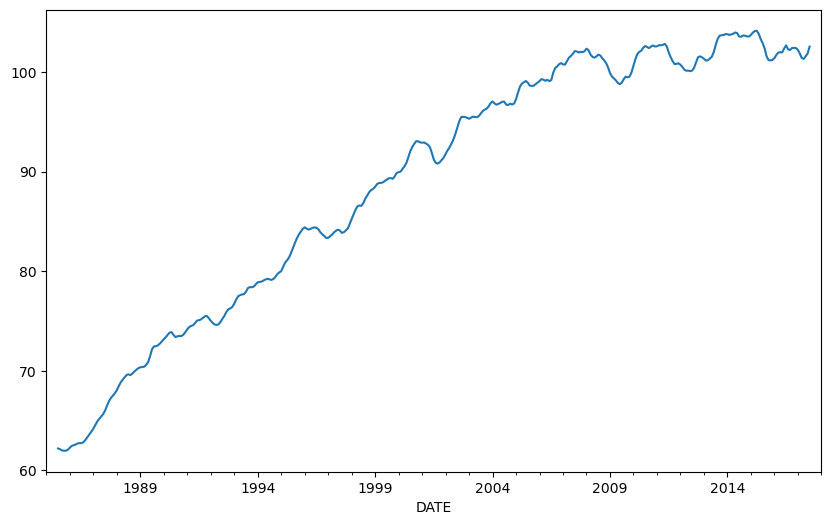

In [17]:
ets_decomposition_plot(df['IPG2211A2N'],'trend')

### Model building

In [18]:
def build_model(timeseries, order = None, show_summary = True):
#     if order is None: # auto-ARIMA
#         model = auto_arima(timeseries, start_p=1, start_q=1,
#                       test='adf',
#                       max_p=4, max_q=4, 
#                       m=1,             
#                       d=None,           
#                       seasonal=False,   
#                       start_P=0, 
#                       D=0, 
#                       trace=True,
#                       error_action='ignore',  
#                       suppress_warnings=True, 
#                       stepwise=True)
#         if show_summary:
#             print(model.summary())
#         return model
    model = ARIMA(timeseries, order=order)
    model_fit = model.fit()
    if show_summary:
        print(model_fit.summary())
    return model_fit
                      

In [19]:
# model = build_model(df['IPG2211A2N'])

In [20]:
# model.order

In [21]:
# model.plot_diagnostics()

In [22]:
model = build_model(df['IPG2211A2N'], order = (4, 0, 2))

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:             IPG2211A2N   No. Observations:                  397
Model:                 ARIMA(4, 0, 2)   Log Likelihood               -1121.635
Date:                Fri, 09 Jun 2023   AIC                           2259.269
Time:                        09:11:02   BIC                           2291.141
Sample:                    01-01-1985   HQIC                          2271.895
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         88.5703     24.945      3.551      0.000      39.679     137.462
ar.L1          0.9397      0.043     21.906      0.000       0.856       1.024
ar.L2          0.1244      0.048      2.604      0.0

/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Forecasting

In [23]:
model.forecast(10)

2018-02-01    118.379881
2018-03-01     97.447893
2018-04-01     85.838786
2018-05-01     94.271901
2018-06-01    110.295831
2018-07-01    119.460386
2018-08-01    112.967146
2018-09-01    100.694192
2018-10-01     93.420744
2018-11-01     98.411020
Freq: MS, Name: predicted_mean, dtype: float64

In [24]:
df.tail(5)

,IPG2211A2N
DATE,
2017-09-01,98.6154
2017-10-01,93.6137
2017-11-01,97.3359
2017-12-01,114.7212
2018-01-01,129.4048


In [25]:
# forecast plotting

fc = model.forecast(15, alpha=0.05) 
pd.Series(fc)

2018-02-01    118.379881
2018-03-01     97.447893
2018-04-01     85.838786
2018-05-01     94.271901
2018-06-01    110.295831
2018-07-01    119.460386
2018-08-01    112.967146
2018-09-01    100.694192
2018-10-01     93.420744
2018-11-01     98.411020
2018-12-01    107.767170
2019-01-01    113.525333
2019-02-01    109.648734
2019-03-01    102.507977
2019-04-01     97.911554
Freq: MS, Name: predicted_mean, dtype: float64

In [26]:
def plot(timeseries, model, periods):
    fig = plt.figure()
    timeseries.plot()
    fc = model.forecast(periods)
    print(len(fc))
    fc.plot()


20


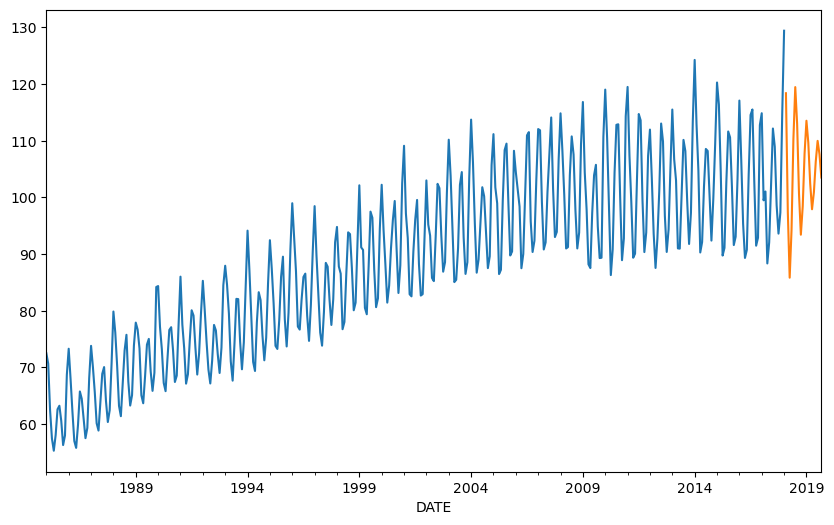

In [27]:
plot(df['IPG2211A2N'], model, 20)

## FINAL ARIMA CLASS

In [363]:
class ModelARIMA:
    def __init__(self):
        self.df = None
        return 
    
    def load_timeseries(self, series: pd.DataFrame):
        self.df = series
    
    def plot_series(self):
        plt.xlabel(df.index.name)
        plt.ylabel(df.columns[0])
        plt.plot(self.df)
        plt.title('Series plot')
    
    def plot_rolling_stats(self, rolling_window: int):
        rolmean = self.df.rolling(window=rolling_window).mean()
        rolstd = self.df.rolling(window=rolling_window).std()
        orig = plt.plot(self.df, color='blue', label='Original')
        mean = plt.plot(rolmean, color='red', label='Rolling Mean')
        std = plt.plot(rolstd, color='black', label='Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')
        plt.show(block=False)
    
    def test_stationarity(self):
        print('Results of Dickey Fuller Test:')
        dftest = adfuller(self.df[self.df.columns[0]], autolag='AIC')
        dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
        for key,value in dftest[4].items():
            dfoutput['Critical Value (%s)'%key] = value
        print(dfoutput)
    
    def acf_differencing_plots(self, max_order):
        fig, axes = plt.subplots(max_order+1, 3)
        axes[0, 0].plot(self.df); axes[0, 0].set_title('Original Series')
        plot_acf(self.df, ax=axes[0, 1])
        plot_pacf(self.df, ax=axes[0, 2])

        for order in range(1, max_order+1):
            axes[order, 0].plot(self.df.diff(order)); axes[order, 0].set_title(str(order)+' Order Differencing')
            plot_acf(self.df.diff(order).dropna(), ax=axes[order, 1])
            plot_pacf(self.df.diff(order).dropna(), ax=axes[order, 2])

        plt.tight_layout()
    
    def ets_decomposition_plot(self, plot = 'all'):
        if plot == 'all':
            seasonal_decompose(self.df[self.df.columns[0]], model = 'multiplicative').plot()
        elif plot == 'seasonal':
            seasonal_decompose(self.df[self.df.columns[0]], model = 'multiplicative').seasonal.plot()
        elif plot == 'error':
            seasonal_decompose(self.df[self.df.columns[0]], model = 'multiplicative').resid.plot()
        elif plot == 'trend':
            seasonal_decompose(self.df[self.df.columns[0]], model = 'multiplicative').trend.plot()
        else:
            print('Incorrect value \''+ plot + '\' for \'plot\'')

    def build_model(self, order = None, show_summary = True):
        if order is None:
            self.auto = True
            model = auto_arima(df, start_p=1, start_q=1,
                      test='adf',       
                      max_p=5, max_q=5, 
                      m=1,             
                      d=None,           
                      seasonal=False,   
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
            self.model_fit = model
            if show_summary:
                print(model.summary())
        else:
            self.auto = False
            model = ARIMA(self.df, order=order)
            model_fit = model.fit()
            if show_summary:
                print(model_fit.summary())
            self.model_fit = model_fit
            print('Model built successfully.')
    
    def plot_forecast(self, periods):
        if not self.auto:
            fig = plt.figure()
            self.df.plot(label = 'Series')
            fc = self.model_fit.forecast(periods)
            fc.plot(label = 'Forecast')
        else:
            fig = plt.figure()
            df.plot(label = 'Series')
            fc = self.model_fit.predict(periods)
            fc.plot(label = 'Forecast')
    
    def get_forecasts(self, periods):
        if not self.auto:
            return self.model_fit.forecast(periods)
        else:
            return self.model_fit.predict(periods)
    
    def error_metrics(self, test_series):
        actual = test_series[test_series.columns[0]].to_numpy()
        forecast = self.get_forecasts(len(actual)).values
#         print(forecast.shape, actual.shape)
        mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  
        me = np.mean(forecast - actual)             
        mae = np.mean(np.abs(forecast - actual)) 
        mpe = np.mean((forecast - actual)/actual) 
        rmse = np.mean((forecast - actual)**2)**.5  
        corr = np.corrcoef(forecast, actual)[0,1]   
        mins = np.amin(np.hstack([forecast[:,None], actual[:,None]]), axis=1)
        maxs = np.amax(np.hstack([forecast[:,None], actual[:,None]]), axis=1)
        minmax = 1 - np.mean(mins/maxs)             
#         acf1 = acf(fc-test)[1]
        return (pd.Series({'mape':mape, 'me':me, 'mae': mae, 
                'mpe': mpe, 'rmse':rmse, 'minmax':minmax}))

    def plot_test_forecast(self, test_series):
        if not self.auto:
            ax = self.df.plot()
            test_series.plot(ax = ax, color = 'g')
            fc = self.model_fit.forecast(len(test_series))
            fc.plot(ax = ax, color = 'r')
            plt.show()
        else:
            ax = df.plot(label = 'Series')
            test_series.plot(ax = ax, color = 'gr')
            fc = self.model_fit.predict(len(test_series))
            fc.plot(ax = ax, color = 'r')
            plt.show()

In [364]:
df = pd.read_csv('/kaggle/input/time-series-practice-dataset/train.csv')
df = pd.DataFrame(df[df['store'] == 0])
df = pd.DataFrame(df[df['product'] == 0])
df['product'].value_counts()

0    3287
Name: product, dtype: int64

In [365]:
df.drop(['store', 'product'], axis = 1, inplace = True)
df['Date'] = pd.to_datetime(df['Date'],infer_datetime_format=True)
df = df.set_index(['Date'])
df.head()

,number_sold
Date,
2010-01-01,801
2010-01-02,810
2010-01-03,818
2010-01-04,796
2010-01-05,808


In [366]:
arima = ModelARIMA()
arima.load_timeseries(df)

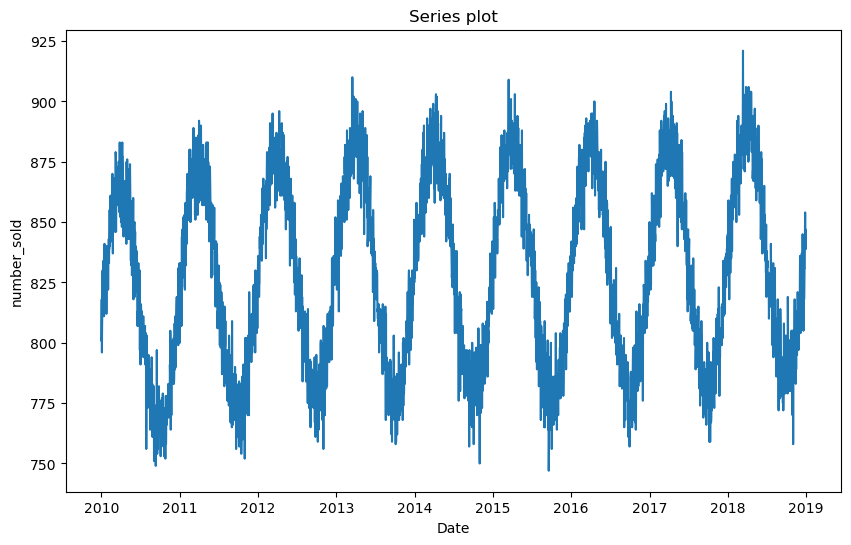

In [367]:
arima.plot_series()

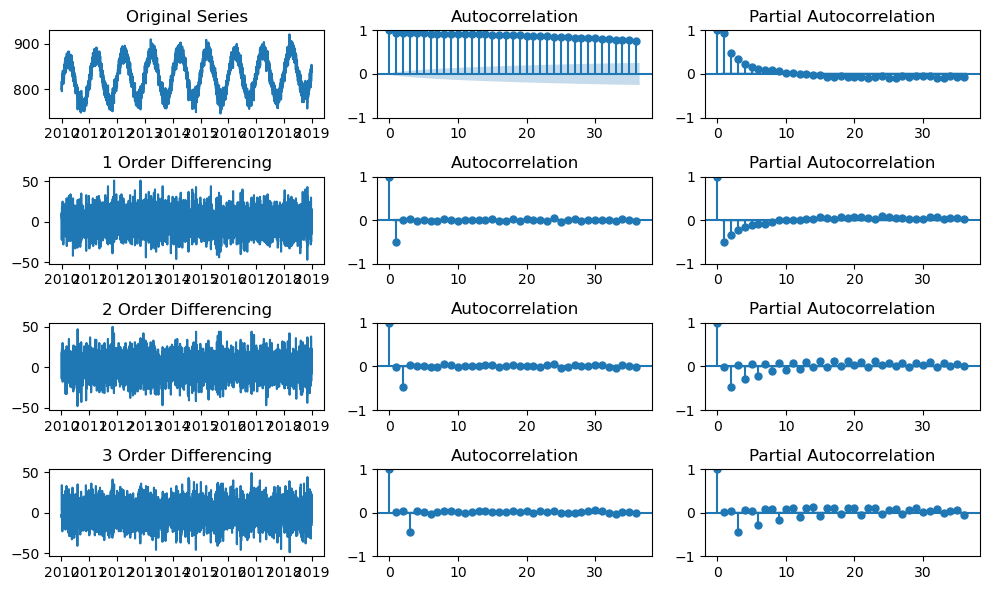

In [368]:
arima.acf_differencing_plots(3)

In [369]:
arima.build_model((1,1,2))

                               SARIMAX Results                                
Dep. Variable:            number_sold   No. Observations:                 3287
Model:                 ARIMA(1, 1, 2)   Log Likelihood              -12366.339
Date:                Fri, 09 Jun 2023   AIC                          24740.679
Time:                        10:59:41   BIC                          24765.068
Sample:                    01-01-2010   HQIC                         24749.411
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9928      0.002    408.159      0.000       0.988       0.998
ma.L1         -1.9014      0.007   -258.590      0.000      -1.916      -1.887
ma.L2          0.9094      0.007    123.867      0.0

In [370]:
arima.get_forecasts(20)

2019-01-01    841.745682
2019-01-02    842.684379
2019-01-03    843.616351
2019-01-04    844.541648
2019-01-05    845.460317
2019-01-06    846.372406
2019-01-07    847.277961
2019-01-08    848.177030
2019-01-09    849.069659
2019-01-10    849.955894
2019-01-11    850.835782
2019-01-12    851.709366
2019-01-13    852.576693
2019-01-14    853.437808
2019-01-15    854.292754
2019-01-16    855.141577
2019-01-17    855.984319
2019-01-18    856.821025
2019-01-19    857.651738
2019-01-20    858.476500
Freq: D, Name: predicted_mean, dtype: float64

In [372]:
test = pd.read_csv('/kaggle/input/time-series-practice-dataset/test.csv')
test = pd.DataFrame(test[test['store'] == 0])
test = pd.DataFrame(test[test['product'] == 0])
test.drop(['store', 'product'], axis = 1, inplace = True)
test['Date'] = pd.to_datetime(test['Date'],infer_datetime_format=True)
test = test.set_index(['Date'])
test.head()

,number_sold
Date,
2019-01-01,845
2019-01-02,851
2019-01-03,840
2019-01-04,842
2019-01-05,845


In [373]:
arima.error_metrics(test)

mape       0.095706
me        75.976640
mae       78.968935
mpe        0.092336
rmse      98.404327
minmax     0.083293
dtype: float64

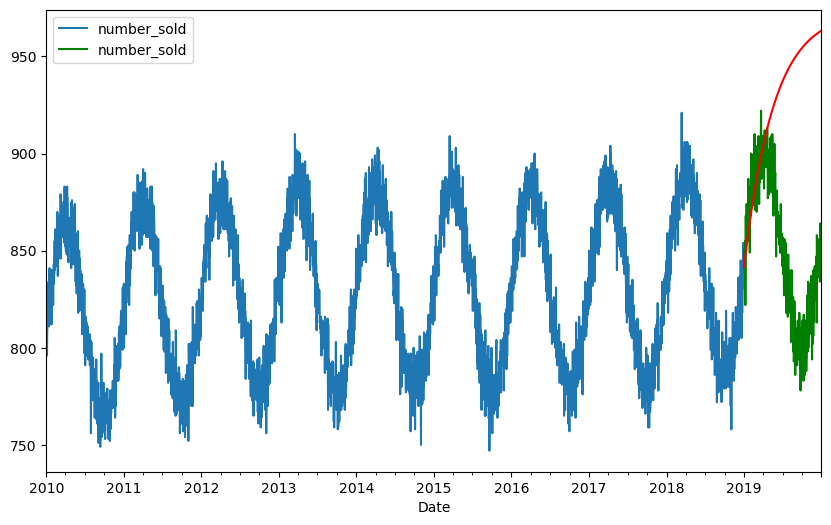

In [374]:
arima.plot_test_forecast(test)